In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-eeg-model/EEG_ML_MODEL/scales.xls
/kaggle/input/my-eeg-model/EEG_ML_MODEL/Coordinates.locs
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Arithmetic_sub_19_trial3.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Relax_sub_23_trial3.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Relax_sub_4_trial2.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Mirror_image_sub_8_trial3.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Relax_sub_4_trial3.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Relax_sub_24_trial2.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Mirror_image_sub_9_trial3.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Mirror_image_sub_23_trial2.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Stroop_sub_15_trial1.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Mirror_image_sub_21_trial3.mat
/kaggle/input/my-eeg-model/EEG_ML_MODEL/filtered_data/Mirror_image_sub_13_trial1.m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Columns: 3200 entries, 0 to 3199
dtypes: float64(3200)
memory usage: 800.1 KB


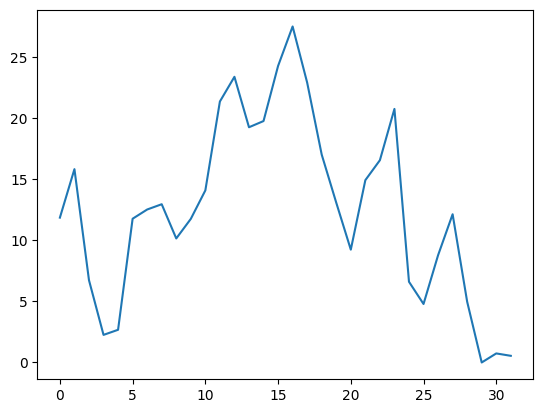

In [2]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

# Load data from .mat file
mat_data = scipy.io.loadmat('/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_10_trial3.mat')

# Convert data to pandas DataFrame
df = pd.DataFrame(mat_data['Data'])
df.info()
df.head()


# Plot first column of DataFrame
plt.plot(df.iloc[:,0])
plt.show()

In [4]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

mat_data = scipy.io.loadmat('/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_10_trial3.mat')

# List all available keys
print("Keys in .mat file:", mat_data.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'Data'])


/tmp/ipykernel_35/4246066196.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


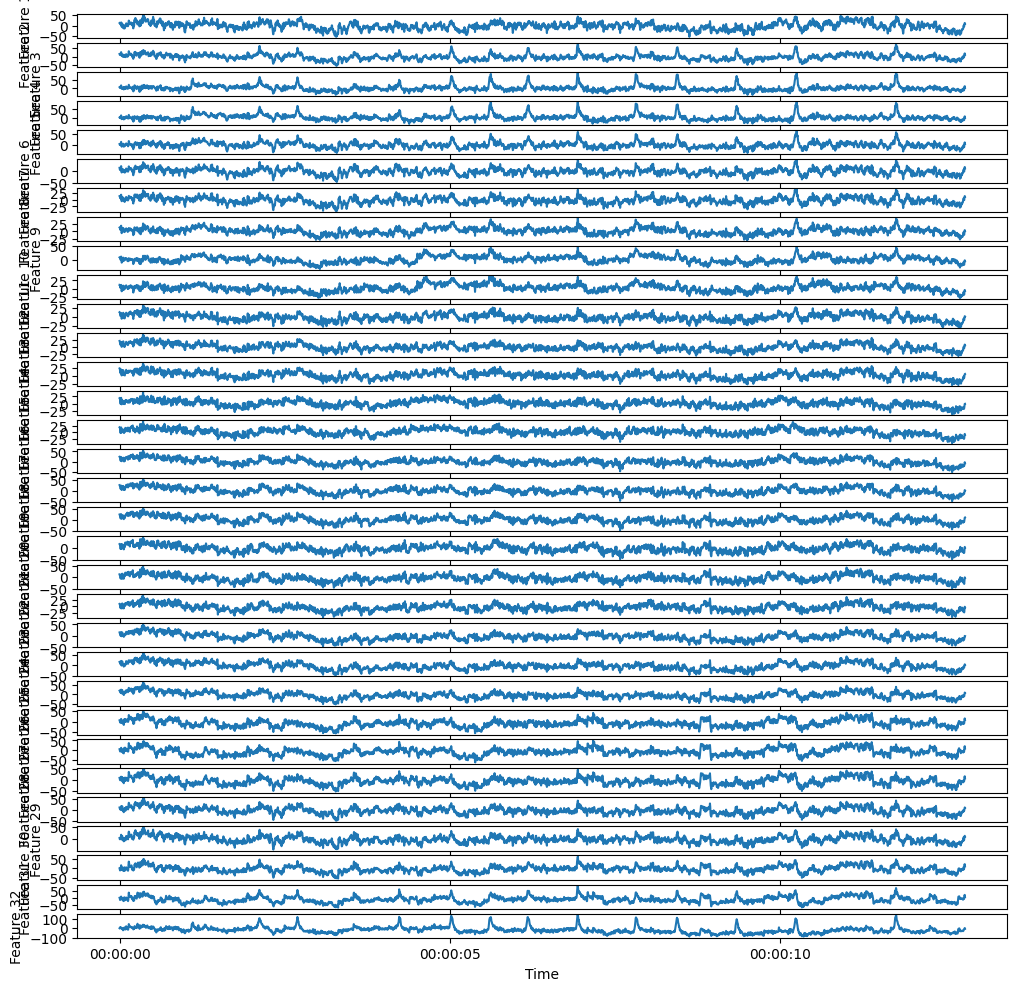

In [6]:
import scipy.io
import pandas as pd

import matplotlib.pyplot as plt

# Load data from .mat file
mat_data = scipy.io.loadmat('/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_10_trial3.mat')

# Convert data to pandas DataFrame and transpose it
df = pd.DataFrame(mat_data['Data']).T

# Create time stamps based on the sampling frequency (256 Hz)
time_stamps = pd.date_range(start='1/1/2000', periods=df.shape[0], freq='4ms')

# Plot each feature as a separate subplot
fig, axes = plt.subplots(nrows=df.shape[1], ncols=1, figsize=(12, 12))
for i, ax in enumerate(axes):
    ax.plot(time_stamps, df.iloc[:,i])
    ax.set_ylabel('Feature {}'.format(i+1))

# Set x-axis label to time and adjust the layout
axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

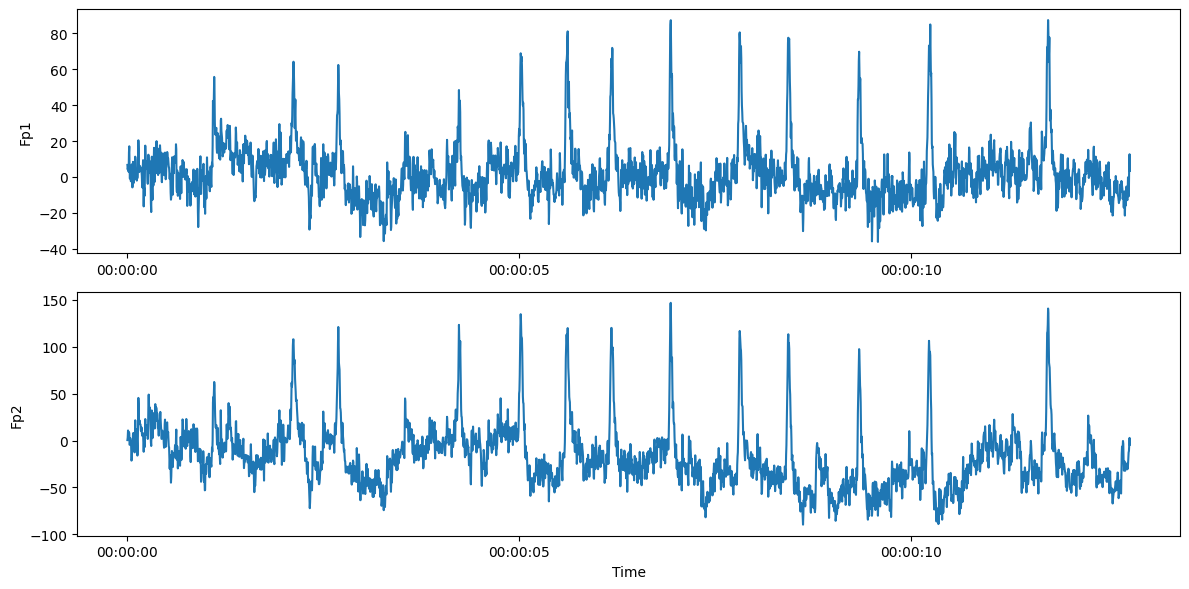

In [7]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

# Load data from .mat file
mat_data = scipy.io.loadmat('/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_10_trial3.mat')

# ✅ Extract only Fp1 (index 2) and Fp2 (index 31)
df = pd.DataFrame(mat_data['Data']).T.iloc[:, [2, 31]]

# Create time stamps based on the sampling frequency (256 Hz)
time_stamps = pd.date_range(start='1/1/2000', periods=df.shape[0], freq='4ms')

# Plot Fp1 and Fp2 as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
channel_names = ['Fp1', 'Fp2']

for i, ax in enumerate(axes):
    ax.plot(time_stamps, df.iloc[:, i])
    ax.set_ylabel(channel_names[i])

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

In [8]:
df

,2,31
0,6.706254,0.518309
1,4.167284,3.211065
2,5.334106,10.775371
3,3.572288,8.283563
4,2.939309,3.144884
...,...,...
3195,-10.756878,-12.678057
3196,-5.842605,-11.157732
3197,9.356821,-3.681518
3198,12.640870,2.857745


In [9]:
def segment_signal(signal, window_size=256):
    return [signal[i:i+window_size] for i in range(0, len(signal) - window_size + 1, window_size)]

In [10]:
segments_fp1 = segment_signal(df.iloc[:, 0])  # Fp1
segments_fp2 = segment_signal(df.iloc[:, 1])  # Fp2

In [11]:
from scipy.signal import welch
import numpy as np

def bandpower(psd, freqs, low, high):
    idx = np.logical_and(freqs >= low, freqs <= high)
    return np.trapz(psd[idx], freqs[idx])

def extract_features(segments, fs=256):
    features = []
    for segment in segments:
        freqs, psd = welch(segment, fs=fs, nperseg=128)
        delta = bandpower(psd, freqs, 1, 4)
        theta = bandpower(psd, freqs, 4, 8)
        alpha = bandpower(psd, freqs, 8, 13)
        beta = bandpower(psd, freqs, 13, 30)
        gamma = bandpower(psd, freqs, 30, 50)
        features.append([delta, theta, alpha, beta, gamma])
    return np.array(features)

In [12]:
features_fp1 = extract_features(segments_fp1)
features_fp2 = extract_features(segments_fp2)

In [13]:
combined_features = np.hstack((features_fp1, features_fp2))  # shape: (samples, 10)

In [14]:
print("Combined features shape:", combined_features.shape)

Combined features shape: (12, 10)


In [15]:
print("First 5 combined feature vectors:\n", combined_features[:5])

First 5 combined feature vectors:
 [[  2.86076592   4.54377916   9.89389276   7.58125231  10.77663748
   53.53673693  27.88541039  26.90825298  28.13472793  30.05910711]
 [  6.28942027  11.11938897   7.48644558   7.05915935   4.25413499
   31.29413288  32.35944197  22.57074895  16.65546568  19.09824183]
 [ 49.68484906  44.74284848  19.74313922  14.6553335    9.6907191
  296.8269229  192.41513367  60.3808257   32.05960916  21.84214191]
 [ 18.32815068  26.65214888   6.58859862   9.08282876  11.1091555
   74.4508841   54.14167768  12.04294736  23.41223199  25.86268177]
 [ 35.50034657  26.05776849  15.47272436  11.9018719    8.15399145
  107.18159497 127.09488415  50.89106385  47.25902867  21.42137244]]


In [16]:
import pandas as pd

columns = ['Fp1_Delta', 'Fp1_Theta', 'Fp1_Alpha', 'Fp1_Beta', 'Fp1_Gamma',
           'Fp2_Delta', 'Fp2_Theta', 'Fp2_Alpha', 'Fp2_Beta', 'Fp2_Gamma']

df_features = pd.DataFrame(combined_features, columns=columns)
print(df_features.head())

   Fp1_Delta  Fp1_Theta  Fp1_Alpha   Fp1_Beta  Fp1_Gamma   Fp2_Delta  \
0   2.860766   4.543779   9.893893   7.581252  10.776637   53.536737   
1   6.289420  11.119389   7.486446   7.059159   4.254135   31.294133   
2  49.684849  44.742848  19.743139  14.655334   9.690719  296.826923   
3  18.328151  26.652149   6.588599   9.082829  11.109155   74.450884   
4  35.500347  26.057768  15.472724  11.901872   8.153991  107.181595   

    Fp2_Theta  Fp2_Alpha   Fp2_Beta  Fp2_Gamma  
0   27.885410  26.908253  28.134728  30.059107  
1   32.359442  22.570749  16.655466  19.098242  
2  192.415134  60.380826  32.059609  21.842142  
3   54.141678  12.042947  23.412232  25.862682  
4  127.094884  50.891064  47.259029  21.421372  


In [17]:
import scipy.io

# load one file from calm folder
calm_file = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/calm_data/Relax_sub_10_trial3.mat'

calm_data = scipy.io.loadmat(calm_file)
print('Calm data shape:', calm_data['Data'].shape)

# load one file from stress folder
stress_file = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_10_trial3.mat'
stress_data = scipy.io.loadmat(stress_file)
print('Stress data shape:', stress_data['Data'].shape)

Calm data shape: (32, 3200)
Stress data shape: (32, 3200)


In [19]:
import scipy.io
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Model

# Load calm file
calm_file = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/calm_data/Relax_sub_10_trial3.mat'
calm_data = scipy.io.loadmat(calm_file)
calm_X = calm_data['Data']
calm_X = np.transpose(calm_X)  # Transpose to get data in shape (time_steps, features)
calm_y = np.zeros(calm_X.shape[0])  # Label as 0 (calm)

# Load stress file
stress_file = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_10_trial3.mat'
stress_data = scipy.io.loadmat(stress_file)
stress_X = stress_data['Data']
stress_X = np.transpose(stress_X)  # Transpose to get data in shape (time_steps, features)
stress_y = np.ones(stress_X.shape[0])  # Label as 1 (stress)

# Concatenate and shuffle data
X = np.concatenate([calm_X, stress_X], axis=0)
y = np.concatenate([calm_y, stress_y], axis=0)
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
split = int(0.8 * X.shape[0])
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

# Reshape data for LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))  # Define input shape explicitly
model.add(LSTM(128, return_sequences=True))  # LSTM layer 1
model.add(Dropout(0.2))  # Dropout layer 1
model.add(LSTM(64))  # LSTM layer 2
model.add(Dropout(0.2))  # Dropout layer 2
model.add(Dense(1, activation='sigmoid'))  # Output layer


# Compile and fit model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32)

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
# Save the trained model
model.save('my_model.h5')


2025-06-18 06:52:41.808091: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8221 - loss: 0.4236
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9142 - loss: 0.2293
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9134 - loss: 0.2276
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9312 - loss: 0.1921
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9352 - loss: 0.1923
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9383 - loss: 0.1811
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9364 - loss: 0.1779
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9300 - loss: 0.1924
Epoch 9/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9310 - loss: 0.1837
Epoch 10/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9373 - loss: 0.1777
Epoch 11/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9379 - loss: 0.1736
Epoch 12/30
160/160 ━━━━━━━━━━━━━━━━━━━━

In [20]:
from sklearn.model_selection import StratifiedKFold

# Split the data into 5 stratified folds (ensures class distribution is similar across all folds)
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# This is where the actual cross-validation happens
for train_idx, val_idx in kfold.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]  # Training and validation data
    y_train, y_val = y[train_idx], y[val_idx]  # Corresponding labels

    # Reshaping input data as required by your model (e.g., if using LSTM or CNN)
    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32)

    # Evaluate on the validation fold (this is where the model is tested on data it hasn't seen during training)
    val_loss, val_acc = model.evaluate(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val)

    # Output the validation accuracy and loss for this fold
    print(f"Validation accuracy: {val_acc}, Validation loss: {val_loss}")

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9869 - loss: 0.0397
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9933 - loss: 0.0214
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9924 - loss: 0.0202
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9881 - loss: 0.0296
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9903 - loss: 0.0321
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9917 - loss: 0.0228
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9963 - loss: 0.0108
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9954 - loss: 0.0153
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9959 - loss: 0.0143
Epoch 10/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9956 - loss: 0.0147
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9973 - loss: 0.0112
Validation accuracy: 0.996874988079071, Validation loss

In [21]:
import numpy as np

# Create lists to store accuracies and losses for each fold
val_accuracies = []
val_losses = []

# Assuming you've already defined kfold and the model fitting process as you've done previously
for train_idx, val_idx in kfold.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train the model on the training data
    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32)
    
    # Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate(X_val.reshape(X_val.shape[0], X_val.shape[1], 1), y_val)
    
    # Append the results to the lists
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    
    # Print the results for each fold
    print(f"Validation accuracy: {val_acc}, Validation loss: {val_loss}")

# After cross-validation, calculate the average validation accuracy and loss
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)

# Print the averages
print(f"Average Validation Accuracy: {avg_val_accuracy}")
print(f"Average Validation Loss: {avg_val_loss}")

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9989 - loss: 0.0042
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9989 - loss: 0.0029
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9981 - loss: 0.0037
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9994 - loss: 0.0027
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 1.0000 - loss: 4.6643e-04
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 1.0000 - loss: 1.7737e-04
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9979 - loss: 0.0047
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 1.0000 - loss: 4.5170e-04
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9987 - loss: 0.0050
Epoch 10/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9879 - loss: 0.0357
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9873 - loss: 0.0384
Validation accuracy: 0.989062488079071, Val

In [22]:
model.fit(X.reshape(X.shape[0], X.shape[1], 1), y, epochs=30, batch_size=32)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9996 - loss: 0.0015
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9979 - loss: 0.0066
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9975 - loss: 0.0067
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9993 - loss: 0.0025
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 1.0000 - loss: 4.4354e-04
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9997 - loss: 0.0014
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9986 - loss: 0.0052
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9997 - loss: 0.0018
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9986 - loss: 0.0036
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 1.0000 - loss: 3.6205e-04
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 1.0000 - loss: 1.2693e-04
Epoch 12/30
200/200 ━━━━━━━━━

In [25]:
import scipy.io
import numpy as np
from tensorflow.keras.models import load_model

# Define the function to apply preprocessing steps to the data
def apply_preprocessing(data):
    # Define the preprocessing steps to apply to the data
    # For example:
    # data = preprocess_data(data)
    # data = apply_filter(data)
    # data = apply_feature_extraction(data)
    return data

# Load the saved model
model = load_model('my_model.h5')

# Prepare the new input data
calm_file = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Mirror_image_sub_13_trial1.mat'
new_data = scipy.io.loadmat(calm_file)
new_data = new_data['Data']
new_data = new_data.reshape(-1, 32)  # reshape the new data to have shape (num_samples, num_features)
# Apply preprocessing steps to the new data
new_data = apply_preprocessing(new_data)

# Scale the new data using the same scaler used for training
new_data = scaler.transform(new_data)

num_samples = new_data.shape[0]
num_features = new_data.shape[1]

new_data = new_data.reshape((num_samples, num_features, 1))  # reshape back to original shape (num_samples, num_features, 1) for input to the model

# Make predictions on the new data
y_pred = model.predict(new_data)

# Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype('int32')

# Print whether the input graph has high or low stress
if y_pred_labels[0] == 0:
    print('The input graph has low stress.')
else:
    print('The input graph has high stress.')

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
The input graph has high stress.


In [26]:
import scipy.io
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Define paths to calm and stress folders
calm_folder = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/calm_data'
stress_folder = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data'

# Load calm files
calm_X = []
for i, filename in enumerate(os.listdir(calm_folder)):
    if filename.endswith(".mat") and i < 16:
        file_path = os.path.join(calm_folder, filename)
        data = scipy.io.loadmat(file_path)
        X = data['Data']
        X = np.transpose(X)  # Transpose to get data in shape (time_steps, features)
        calm_X.append(X)
calm_X = np.concatenate(calm_X, axis=0)
calm_y = np.zeros(calm_X.shape[0])  # Label as 0 (calm)

# Load stress files
stress_X = []
for i, filename in enumerate(os.listdir(stress_folder)):
     if filename.endswith(".mat") and i < 16:
        file_path = os.path.join(stress_folder, filename)
        data = scipy.io.loadmat(file_path)
        X = data['Data']
        X = np.transpose(X)  # Transpose to get data in shape (time_steps, features)
        stress_X.append(X)
stress_X = np.concatenate(stress_X, axis=0)
stress_y = np.ones(stress_X.shape[0])  # Label as 1 (stress)

# Concatenate and shuffle data
X = np.concatenate([calm_X, stress_X], axis=0)
y = np.concatenate([calm_y, stress_y], axis=0)
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
split = int(0.8 * X.shape[0])
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile and fit model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=32)

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
# Save the trained model
model.save('my_model.h5')


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 72s 26ms/step - accuracy: 0.6837 - loss: 0.5656
Epoch 2/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.8435 - loss: 0.3377
Epoch 3/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.8844 - loss: 0.2642
Epoch 4/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.9101 - loss: 0.2124
Epoch 5/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.9241 - loss: 0.1807
Epoch 6/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.9357 - loss: 0.1571
Epoch 7/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.9452 - loss: 0.1371
Epoch 8/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.9531 - loss: 0.1177
Epoch 9/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 67s 26ms/step - accuracy: 0.9595 - loss: 0.1040
Epoch 10/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - accuracy: 0.9620 - loss: 0.0984
Epoch 11/30
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 68s 26ms/step - accuracy: 0.9650 - loss: 0.0906
Epoch 12/30
2560/25

In [27]:
import scipy.io
import numpy as np
from tensorflow.keras.models import load_model

# Define the function to apply preprocessing steps to the data
def apply_preprocessing(data):
    # Define the preprocessing steps to apply to the data
    # For example:
    # data = preprocess_data(data)
    # data = apply_filter(data)
    # data = apply_feature_extraction(data)
    return data

# Load the saved model
model = load_model('/kaggle/working/my_model.h5')

# Prepare the new input data
calm_file = '/kaggle/input/my-eeg-model/EEG_ML_MODEL/raw_folder/stress_data/Arithmetic_sub_18_trial2.mat'
new_data = scipy.io.loadmat(calm_file)

new_data = new_data['Data']
new_data = new_data.reshape(-1, 32)  # reshape the new data to have shape (num_samples, num_features)

# Apply preprocessing steps to the new data
new_data = apply_preprocessing(new_data)

# Scale the new data using the same scaler used for training
new_data = scaler.transform(new_data)

num_samples = new_data.shape[0]
num_features = new_data.shape[1]

new_data = new_data.reshape((num_samples, num_features, 1))  # reshape back to original shape (num_samples, num_features, 1) for input to the model

# Make predictions on the new data
y_pred = model.predict(new_data)

# Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype('int32')

# Print whether the input graph has high or low stress
if y_pred_labels[0] == 0:
    print('The input graph has low stress.')
else:
    print('The input graph has high stress.')

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
The input graph has high stress.


In [28]:
np = model.layers[0].get_weights()
np


[array([[ 0.42402467,  0.24606985,  0.57387537, -0.08954286, -0.19242804,
         -0.20924523, -0.06814305, -0.42519447,  0.11454131,  0.29738238,
          0.16577376, -0.37496752,  0.44953045, -0.83254707, -0.2738885 ,
         -0.21908244,  0.10105257,  0.7516592 ,  0.7435906 , -0.4599972 ,
         -0.10445306, -0.9003605 ,  0.26313597, -0.57791847, -0.5921108 ,
          0.6836676 ,  0.07292055, -0.10980051,  0.28984   ,  0.35722348,
          0.02169649, -0.4061352 ,  0.0506261 ,  0.4470134 , -0.05260573,
         -0.1995532 ,  0.7996063 ,  0.04810287,  0.36980245,  0.6656351 ,
         -0.58650607, -0.03803302, -0.18056427, -0.01121759,  0.73827773,
          0.4274416 , -0.13719256,  0.12402803, -0.06496244,  0.26083225,
          0.54223925, -0.55553204,  0.46870765,  0.25280434, -0.3204657 ,
          0.15895237,  0.44256738,  0.5670203 , -0.45891562, -0.3101392 ,
          0.06177905,  0.22456878,  0.5403536 ,  0.7854046 , -0.2832365 ,
         -0.07631834,  0.2628047 ,  0.

In [29]:
len(np)

3

In [30]:
import numpy as np

weights = np.asarray(model.layers[0].get_weights(), dtype=object)
print(weights.shape)

(3,)
